In [169]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import scipy.io.wavfile as wav
from IPython.display import Audio as ipAD
import pandas as pd
from python_speech_features import mfcc
import IPython

In [170]:
from time import time
now = time()

In [368]:
def get_energy_frames(audio,threshold,norm=0):
    '''
    Calcula a energia que os frames dos áudios carregam.
    Utilizada para a identificação de atividade da voz em situações
    que o silêncio é pouco ruidoso.
    '''
    energy_frames = []
    for i in range(0,len(audio),16):
        if i+16 < len(audio):
            energy_frames.append(sum(np.abs(audio[i:i+16])))
            
  # Filtragem da energia que representa o som
    cv_energy = np.array(energy_frames)
    thresholders = cv_energy < threshold
    cv_energy[thresholders] = 0
  
  # Filtro de porcentagem de áudio
    if norm == 0:
        return cv_energy
    else:
      pass

def stop_list(cv_energy,SILENCE):
    '''
    Identifica os pontos do audio em que há o silencio
    a partir de um limiar.
    ex: se permaneceu silencio por X segundos, anotar o 
    ponto de começo e final.
    
    Retorna uma lista com esses pontos.
    '''
    somatorio = []
    sequencia = 0
    num_seq = 0 
    idx = 0
    start_idx = []

    for i in range(cv_energy.shape[0]):
        signal = cv_energy[i]
        last_signal = cv_energy[i-1]
        if last_signal == 0 and signal == 0:
            num_seq += 1

            if sequencia == 0:
                sequencia = 1
                idx = i


        elif signal !=0:
            if num_seq !=0:
                somatorio.append(num_seq)
                if num_seq > SILENCE:
                    start_idx.append([idx*16,num_seq*15])
                num_seq = 0
            if sequencia == 1:
                sequencia = 0
                num_seq = 0
    return start_idx

def wav_cutter(start_idx,sig):
    '''
    Baseado nos pontos em que foi identificado o silencio, é adicionado
    um buffer baseado no próximo ponto com o início e final do áudio.
    
    Retorna arquivos wav por ponto de corte.
    '''
    
    wav_cuts = []
    for i in range(len(start_idx)):
        if i+1 < len(start_idx):
            buffer = start_idx[i+1][1]
            end = start_idx[i+1][0]
            if i == 0:
                start=0
            new_audio = sig[start:end+buffer]
        else:
            new_audio = sig[start:]

        wav_cuts.append([new_audio])
        start= end+buffer
    return wav_cuts


def reader_mfcc(array,sample_rate):
    '''
    Calcula o MFCC do audio.
    
    Retorna uma matriz com os vetores característica.
    '''
    mfcc_feat = np.array(mfcc(array,sample_rate))
    y_size = int(mfcc_feat.shape[0]/10)
    if y_size > 0:
        mean = np.zeros((y_size,mfcc_feat.shape[1]))
        for i in range(0,y_size):
            mean[i] = np.mean(mfcc_feat,axis=0)
    return mfcc_feat,mean


def concatenator(start,end, audio_list):
    '''
    Função auxiliar a audio_from_list, concatena os conjuntos 
    de áudio que pertencem ao mesmo locutor.
    
    Retorna os blocos de áudio por locutor.
    '''
    chunk = np.array([],dtype='int16')
    print('concatenating from {} to {}'.format(start,end))
    for i in range(start,end):
        chunk = np.concatenate((chunk,audio_list[i][0]))
    return chunk


def audio_from_list(position_cuts,audio_list):
    '''
    Função que recebe os pontos de corte por cada locutor,
    concatena as partes entre esses pontos de distinção e salva
    os áudios por locutor.
    
    Retorna os nomes dos arquivos criados.
    '''
    names = []
    size = len(audio_list)
    for i in range(len(position_cuts)):
        if i+1 < len(position_cuts):
            start = position_cuts[i]
            end = position_cuts[i+1]
            print('start : {}, end : {}'.format(start,end))
        else:
            start = position_cuts[i]
            end = len(audio_list)
            print('start : {}, end : {}'.format(start,end))
        audio_cut = concatenator(start,end,audio_list)
        wav_name = r'cortado_{}.wav'.format(i)
        names.append(wav_name)
        wav.write(wav_name,16000,audio_cut)
    return names
    

In [393]:
audio,_ = librosa.load(r'audio/pessoas/douglas/cv_2.wav',sr = 16000)
(rate,sig) = wav.read(r'audio/pessoas/douglas/cv_2.wav')

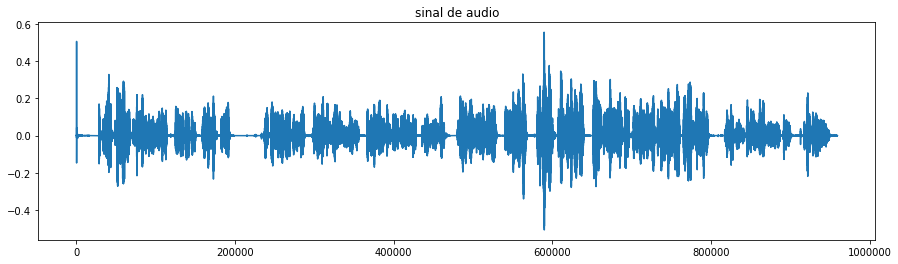

In [395]:
fig = plt.figure(figsize=(15,4))
plt.plot(audio)
plt.title('sinal de audio')
plt.show()
ipAD(r'audio/pessoas/douglas/cv_2.wav')

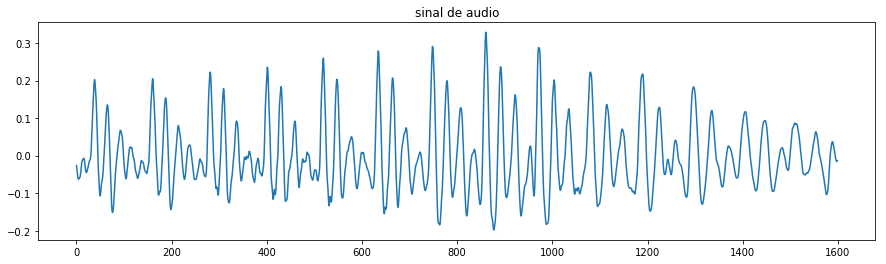

In [396]:
fig = plt.figure(figsize=(15,4))
plt.plot(audio[40000:41600])
plt.title('sinal de audio')
plt.show()

In [397]:
cv_energy = get_energy_frames(audio,1)
start_idx = stop_list(cv_energy,300)

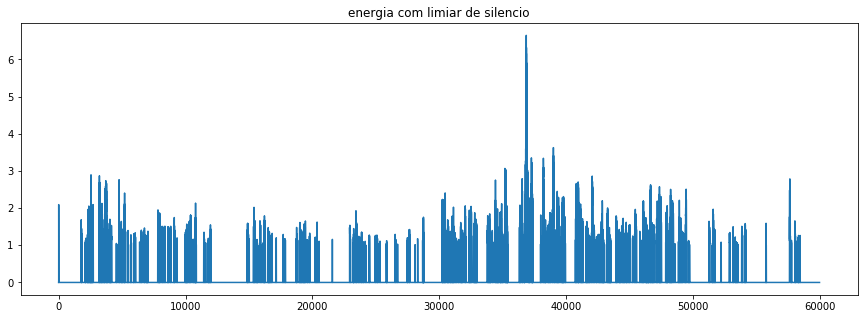

In [398]:
fig = plt.figure(figsize=(15,5))
plt.plot(cv_energy)
plt.title('energia com limiar de silencio')
plt.show()

In [399]:
wav__files = wav_cutter(start_idx,sig)

In [390]:
for wav_f in wav__files[:2]:
    print(wav_f[0])

[   0    0    0 ... -280 -329   35]
[ 354  236 -219 ...  170 -826  399]


In [400]:
import pandas as pd

# cria dataframe das caracteristicas de todos os audios
df = pd.DataFrame(columns=[c for c in range(14)])

# preenche o dataframe com os dados e categoriza de qual audio é cada bloco
for i in range(len(wav__files)):
    t_feat,t_mean = reader_mfcc(wav__files[i][0],16000)
    row_size = t_mean.shape[0]
    new_column = np.ones((row_size,1)) * i
    t_mean = np.concatenate((t_mean,new_column),axis=1)
    temp_df = pd.DataFrame(t_mean,columns = [c for c in range(14)])
    df= df.append(temp_df,ignore_index=True)



In [401]:
from sklearn.cluster import KMeans
X = df.iloc[:,:13]

# aplica kmeans para clusterizar os dados
kmeans = KMeans(n_clusters=2).fit(X)
pred = kmeans.predict(X)
df[14] = pred

breaks = []
ant=3
# verifica a qual pessoa o audio pertece
uniq = df[13].unique()
for item in uniq:
    chunk = df[df[13] == item]
    act = sum(chunk[14]/len(chunk))>0.5
    if act != ant:
        breaks.append(int(item))
    ant = act
breaks

[0, 1, 4, 5, 6, 7, 8, 20, 26]

In [402]:
names = audio_from_list(breaks,wav__files)

start : 0, end : 1
concatenating from 0 to 1
start : 1, end : 4
concatenating from 1 to 4
start : 4, end : 5
concatenating from 4 to 5
start : 5, end : 6
concatenating from 5 to 6
start : 6, end : 7
concatenating from 6 to 7
start : 7, end : 8
concatenating from 7 to 8
start : 8, end : 20
concatenating from 8 to 20
start : 20, end : 26
concatenating from 20 to 26
start : 26, end : 32
concatenating from 26 to 32


In [225]:
import io
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/users/douglas/Desktop/i2a2/i2a2health/CREDENT.json'

# Imports the Google Cloud client library
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

In [167]:
# Instantiates a client
client = speech.SpeechClient()
jsons = {'conversa':[]}

for i in range(len(names)):
    file_name = names[i]
    
    # Loads the audio into memory
    with io.open(file_name, 'rb') as audio_file:
        content = audio_file.read()
        audio = types.RecognitionAudio(content=content)

    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code='pt-BR')

    # Detects speech in the audio file
    response = client.recognize(config, audio)
    for result in response.results:
        IPython.display.display(ipAD(file_name))
        print(result.alternatives[0].transcript)
        if i%2==0:
            jsons['conversa'].append({'locutor':0,'texto':str(result.alternatives[0].transcript)})
        else:
            jsons['conversa'].append({'locutor':1,'texto':str(result.alternatives[0].transcript)})

KeyboardInterrupt: 

In [94]:
end = time()
end-now

25.765114784240723

In [140]:
jsons['conversa'] = [{'locutor': 0,'texto': 'bom dia Gabriel'},
                    {'locutor': 1,'texto': 'bom dia doutor'},
                    {'locutor': 0,'texto': 'o que voce esta sentindo gabriel'},
                     {'locutor': 1,'texto': 'estou com dor de barriga doutor'},
                     {'locutor': 0,'texto': 'ha quantos dias'},
                     {'locutor': 1,'texto': 'fazem seis dias'}
                    ]

jsons

{'conversa': [{'locutor': 0, 'texto': 'bom dia Gabriel'},
  {'locutor': 1, 'texto': 'bom dia doutor'},
  {'locutor': 0, 'texto': 'o que voce esta sentindo gabriel'},
  {'locutor': 1, 'texto': 'estou com dor de barriga doutor'},
  {'locutor': 0, 'texto': 'ha quantos dias'},
  {'locutor': 1, 'texto': 'fazem seis dias'}]}

In [152]:
import requests

r = requests.post('https://03482d04.ngrok.io/rest/send/',json=jsons)

In [153]:
r.text

'{"retorno_articulate": [{"txt": "bom dia Gabriel", "rsp": "responder_saudacao"}, {"txt": "bom dia doutor", "rsp": "responder_saudacao"}, {"txt": "o que voce esta sentindo gabriel", "rsp": "responder sintoma"}, {"txt": "estou com dor de barriga doutor", "rsp": "Modifier"}, {"txt": "ha quantos dias", "rsp": "responder_pergunta_duracao"}, {"txt": "fazem seis dias", "rsp": "expressar_tempo"}]}'

In [371]:
t_mean

array([[ 18.91453044, -17.75056192,  -3.32715934,   2.91381767,
        -32.97420537, -13.52626277,  13.2048439 , -21.6497703 ,
        -26.3678433 ,   1.65790352,  -6.97941925,   0.19179154,
         -1.4032761 ]])